## Part 2: Running Multiple Seeds

The code implementation is concise and customisable. Because research is often fast-moving and often involves unstructured exploration, we suggest creating copies of the code instead of trying to modularise it. Below, we copied the code from `ppo.py`

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import FlattenObservationWrapper, LogWrapper

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class TransitionModel(nn.Module):
    state_dim: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x))
        x = nn.relu(nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x))
        pred = nn.Dense(
            self.state_dim, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        return pred


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
        transition_model = TransitionModel(env.action_space(env_params).n)
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        transition_model_params = transition_model.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        tx_transition_model = optax.adam(learning_rate=1e-3)
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )
        transition_model_train_state = TrainState.create(
            apply_fn=transition_model.apply,
            params=transition_model_params,
            tx=tx_transition_model,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: 

Let's try running one instance of CartPole-v1!

In [3]:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 4,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e5,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "Asterix-MinAtar",
    "ANNEAL_LR": True,
}

rng = jax.random.PRNGKey(42)
train_jit = jax.jit(make_train(config))
out = train_jit(rng)

/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/jax/_src/ops/scatter.py:89: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/jax/_src/ops/scatter.py:89: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


time: 50.88 s


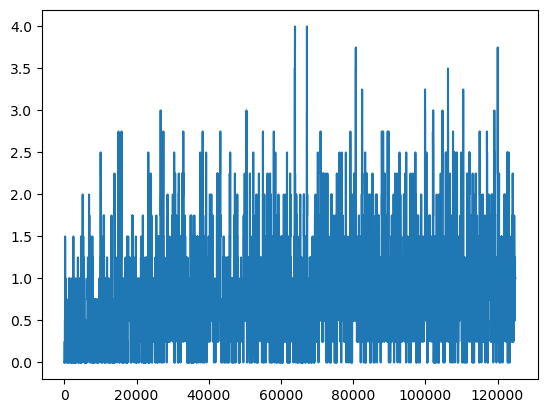

In [4]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.show()

That was pretty fast! But now, let's try running many seeds in parallel. Let's try 256. Note that the first time you run it, it will first spend time JIT compiling the code. Each run after that should be faster than the first.

/home/augustine/anaconda3/envs/cleanrl_jax/lib/python3.8/site-packages/jax/_src/ops/scatter.py:89: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


time: 126.68 s


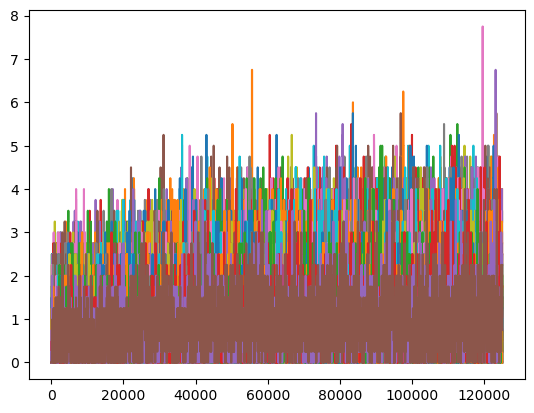

In [5]:
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 256)
train_vjit = jax.jit(jax.vmap(make_train(config)))
t0 = time.time()
outs = jax.block_until_ready(train_vjit(rngs))
print(f"time: {time.time() - t0:.2f} s")

for i in range(256):
    plt.plot(outs["metrics"]["returned_episode_returns"][i].mean(-1).reshape(-1))
plt.show()

## Part 3: Rapid Hyperparameter Search

Is `0.01` the best entropy coefficient for CartPole? We can run a statistically-significant number of seeds for multiple values of it in parallel to do rapid hyperparameter search!

Let's first edit the `train` function to take in the `ENT_COEF` directly instead of through the config.

We just change two lines of code:
1. Put in `ent_coef` as an argument for `train()`
2. Use the `ent_coef` variable instead of the config in `_loss_fn()`

In [6]:
def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(ent_coef, rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - ent_coef * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

Now, We can `vmap` across different values for the entropy coefficient and also `vmap` across different values for the `rngs`!

This means we call `vmap` twice to evaluate the different entropy coefficient on the same set of seeds.

time: 76.51 s


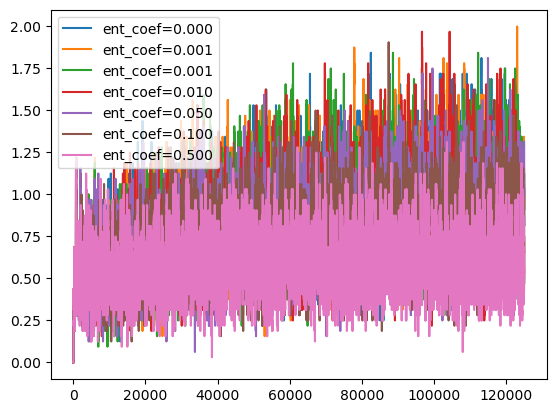

In [7]:
ent_coef_search = jnp.array([0.0, 0.001, 0.0005, 0.01, 0.05, 0.1, 0.5])

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 8)

train_vvjit = jax.jit(
    jax.vmap(
        jax.vmap(
            make_train(config), in_axes=(None, 0)
        ), in_axes=(0, None)
    )
)
t0 = time.time()
outs = jax.block_until_ready(train_vvjit(ent_coef_search, rngs))
print(f"time: {time.time() - t0:.2f} s")

for i in range(len(ent_coef_search)):
    plt.plot(outs["metrics"]["returned_episode_returns"][i].mean(0).mean(-1).reshape(-1), label="ent_coef={:.3f}".format(ent_coef_search[i]))
plt.legend()
plt.show()